In [21]:
## IMPORTS



import pandas as pd
import numpy as np
import h5py
import glob
import scipy
from scipy import optimize
from scipy.optimize import curve_fit


######### gabe hacky styling to emulate some of PBoC Phillips lab style conventions, however hacky. tries to make easier for nigel++
## Styling
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import matplotlib.colors as mcolors
import matplotlib.cm as cm
# sns.set_style('ticks')

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the property to save figures with text as text, not paths
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# default good PBoC colors
baseBlendColor=(224/255, 219/255, 209/255,1) # default background for plots
contrastColor=(209/255, 193/255, 171/255,1) # slightly darker tan for contrasts, e.g. in inset boxes
yellowTanHighlightBoxColor='#FEF0C6'
goodGreyGreenArrowColor='#CCD4C9'


### Griffin style invocation

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.offsetbox import AnchoredText

def plotting_style(grid=False):
    """
    Sets the style to the publication style. To instantiate, simply call
    plotting_style() at the beginning of your script or notebook to force
    all matplotlib plots to adopt the scheme.

    Parameters
    ----------
    grid: bool
      If True, plots will have a thin, white grid in the background. Default
      is False.

    Returns
    -------
    colors: dict
      Returns a dictionary of the standard PBoC 2e color palette.
    """
    rc = {'axes.facecolor': '#E3DCD0',
#               'axes.spines.top': False,
#               'axes.spines.right': False,
#               'axes.spines.left': False,  # Ensure left spine is present
#               'axes.spines.bottom': False,  # Ensure bottom spine is present
#               'axes.spines.left': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
#               'axes.spines.bottom': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
          #'font.family': '/usr/share/fonts/truetype/LucidaSansOT.otf', #'LucidaSansOT.otf',
          'grid.linestyle': '-',
          'grid.linewidth': 0.5,
          'grid.alpha': 0.75,
          'grid.color': '#ffffff',
          'axes.grid': grid,
          'ytick.direction': 'in',
          'xtick.direction': 'in',
          'xtick.gridOn': grid,
          'ytick.gridOn': grid,
#               'ytick.major.width':8,
#               'xtick.major.width':8,
#               'ytick.major.size': 8,
#               'xtick.major.size': 8,
          'mathtext.fontset': 'stixsans',
          'mathtext.sf': 'sans',
          'legend.frameon': True,
          'legend.facecolor': '#FFEDCE',
          'figure.dpi': 150,
          'xtick.color': 'k',
          'ytick.color': 'k'
         }
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('mathtext', fontset='stixsans', sf='sans')
    sns.set_style('darkgrid', rc=rc)
    return color_palette()

def color_palette():
    """
    Returns a dictionary of the PBOC color palette
    """
    return {'green': '#7AA974', 'light_green': '#BFD598',
              'pale_green': '#DCECCB', 'yellow': '#EAC264',
              'light_yellow': '#F3DAA9', 'pale_yellow': '#FFEDCE',
              'blue': '#738FC1', 'light_blue': '#A9BFE3',
              'pale_blue': '#C9D7EE', 'red': '#D56C55', 'light_red': '#E8B19D',
              'pale_red': '#F1D4C9', 'purple': '#AB85AC',
              'light_purple': '#D4C2D9', 'dark_green':'#7E9D90', 'dark_brown':'#905426'}

def titlebox(
    ax, text, color, bgcolor=None, size=8, boxsize=0.1, pad=0.05, **kwargs
):
    """
    Sets a colored title box above the plot, spanning the entire plot width.

    Parameters
    ----------
    ax : matplotlib axis object
      The axis on which you want to add the titlebox.
    text: str
      The title tect
    bgcolor: str or None
      The background color of the title box. Default is no color (blank).
    size:  int
      Size of the text font
    boxsize: float [0, 1]
      Fraction of the total plot height to be occupied by the box. Default is 10% (0.1).
    pad: float
      The padding space between the title box and the top of the plot.

    """
    boxsize=str(boxsize * 100)  + '%'
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size=boxsize, pad=pad)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.spines["top"].set_visible(False)
    cax.spines["right"].set_visible(False)
#     cax.spines["bottom"].set_visible(False)
#     cax.spines["left"].set_visible(False)

#     cax.spines["bottom"].set_visible(True)
#     cax.spines["left"].set_visible(True)
#     cax.spines["left"].set_color("white")
#     cax.spines["bottom"].set_color("white")
#     cax.spines["bottom"].set_color("white")

#     cax.set_ticks_position('both')  # Adding ticks to both top and bottom
#     cax.yaxis.set_tick_params(direction='in', which='both', color='white')  # The bottom will maintain the default of 'out'


    plt.setp(cax.spines.values(), color=color)
    if bgcolor != None:
        cax.set_facecolor(bgcolor)
    else:
        cax.set_facecolor("white")
    at = AnchoredText(text, loc=10, frameon=False, prop=dict(size=size, color=color))
    cax.add_artist(at)


### Now actually call it
plotting_style()

import matplotlib.patheffects as pe
matplotlib.rcParams['axes.autolimit_mode'] = 'data'

In [22]:
def ATP_conc_to_ratio(array, Km, Rmax, Rmin, nhill):
    """Given a set of concentrations, returns ratio values based on provided Hill equation coefficients"""
    return (Rmax-Rmin)*((array/Km)**nhill/(1 + (array/Km))**nhill) + Rmin

def ATP_ratio_to_conc(array, Km, Rmax, Rmin, nhill):
    """Given a set of ratios, returns concentration values based on provided Hill equation coefficients"""
    return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)

In [23]:
#Langmuir equation
def Hill(conc, a, b, c):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)/(1+(conc/a)))+c)



#Curve-fit to the Langmuir curve
def Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 3 entries of parameter guesses for a, b, and c in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = Hill(xvals, param[0], param[1], param[2])
    
    return param, curve, xvals


#Langmuir equation
def Hill_justKd(conc,Kd):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """

    return 2.8*(conc/Kd)/(1+(conc/Kd))



#Curve-fit to the Langmuir curve
def Hill_justKd_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 3 entries of parameter guesses for a, b, and c in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(Hill_justKd, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(1), np.ones([1])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = Hill_justKd(xvals, param[0])
    
    return param, curve, xvals

# probe calibration curve

In [24]:
comsol_cal = '../../data/COMSOL/probeBlurring/20251005_probeCalibration_Qb2pt8A0sweep.csv'
comment='%'
comsol_cal_df = pd.read_csv(comsol_cal, comment=comment, names=["ATP (µM)", "Time (s)", "Qb (µM)"])
comsol_cal_df['Qb (µM)']=comsol_cal_df['Qb (µM)']*1000
comsol_cal_df['ATP (µM)']=comsol_cal_df['ATP (µM)']*1000
comsol_cal_df

,ATP (µM),Time (s),Qb (µM)
0,0.0,4000,0.000000
1,5.0,4000,0.186667
2,10.0,4000,0.350000
3,50.0,4000,1.166667
4,100.0,4000,1.647059
5,500.0,4000,2.456140
6,1000.0,4000,2.616822
7,5000.0,4000,2.761341


In [25]:
comsol_cal_fit = Hill_curve_fit(comsol_cal_df['ATP (µM)'], comsol_cal_df['Qb (µM)'], 5000, [100, 2.8, 0])
comsol_cal_fit_justKd = Hill_justKd_curve_fit(comsol_cal_df['ATP (µM)'], comsol_cal_df['Qb (µM)'], 5000, [100])

In [26]:
comsol_cal_fit_justKd, comsol_cal_fit

((array([69.99999754]),
  array([0.        , 0.0394444 , 0.07779291, ..., 2.76132597, 2.7613336 ,
         2.76134122]),
  array([0.00000000e+00, 1.00020004e+00, 2.00040008e+00, ...,
         4.99799960e+03, 4.99899980e+03, 5.00000000e+03])),
 (array([7.00028106e+01, 2.80000606e+00, 3.43916448e-05]),
  array([3.43916448e-05, 3.94768286e-02, 7.78234720e-02, ...,
         2.76133088e+00, 2.76133851e+00, 2.76134614e+00]),
  array([0.00000000e+00, 1.00020004e+00, 2.00040008e+00, ...,
         4.99799960e+03, 4.99899980e+03, 5.00000000e+03])))

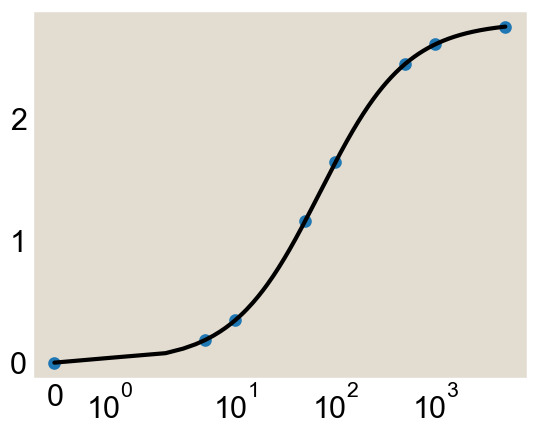

In [27]:
plt.scatter(comsol_cal_df['ATP (µM)'], comsol_cal_df['Qb (µM)'], s=50)
plt.plot(np.linspace(0, 5000, 5001), Hill(np.linspace(0, 5000, 5001), comsol_cal_fit[0][0],comsol_cal_fit[0][1],comsol_cal_fit[0][2]), c='k')
plt.xscale('symlog')

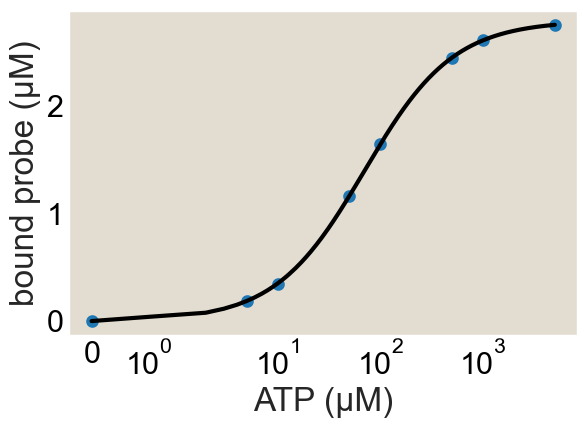

In [28]:
plt.scatter(comsol_cal_df['ATP (µM)'], comsol_cal_df['Qb (µM)'], s=50)
plt.plot(np.linspace(0, 5000, 5001), Hill_justKd(np.linspace(0, 5000, 5001), 70), c='k')
plt.xscale('symlog')
plt.ylabel('bound probe (µM)')
plt.xlabel('ATP (µM)')
plt.tight_layout()
plt.savefig('../../analyzed_data/probeBlurring/QbCalCurve.pdf')

# well depths

In [29]:
molperm3_to_uM = 1e3
mtoum = 1e6

comsol_file_path = '../../data/COMSOL/probeBlurring/'
comsol_file_type = '.csv'
comment = '%'

In [30]:
def comsolTimeGenerator(t_start, t_end, spacing, interval, positions):
    """
    t_start: initial simulation time
    t_end: final simulation time
    spacing: seconds between each simulation measurement
    interval: plotting interval (i.e. do you plot every line? then =1, do you plot every other line? then =2)
    """
    numb_times = int((t_end-t_start)/spacing)+1

    comsol_times = np.linspace(t_start, t_start+spacing*(numb_times-1), numb_times) #given in s
    tot_points = len(positions)
    numb_points = int(tot_points/numb_times)
    
    comsol_time_ls = []
    for t in comsol_times:
        for i in range(numb_points):
            comsol_time_ls.append(t)

    return comsol_time_ls
    

In [31]:
def probeATPcurves(r, a, b):    
    return 500*(1 - b*np.exp(-r**2/a**2))



#Curve-fit to the Langmuir curve
def probeATPcurves_fit(r, probeATP, maxpos, p0): 
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(probeATPcurves, 
                                 r, 
                                 probeATP,
                                 p0, 
                                 bounds = (np.zeros(2), np.ones([2])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxpos,maxpos)
    curve = probeATPcurves(xvals, param[0], param[1])
    
    return param, curve, xvals

# #Curve-fit to the Langmuir curve
# def probeATPcurves_fit(r, probeATP, maxpos, wellDepth, p0): 
#     #Curve fits and returns parameter values as well as the covarience
#     param, param_cov = curve_fit(probeATPcurves, 
#                                  r, 
#                                  probeATP,
#                                  wellDepth,
#                                  p0, 
#                                  bounds = (np.zeros(1), np.ones([1])*np.inf))

#     #stores the new function information according to the coefficients given by curve-fit() function 
#     xvals=np.linspace(0,maxpos,maxpos)
#     curve = probeATPcurves(xvals, param[0], wellDepth)
    
#     return param, curve, xvals


In [32]:
#note this set already had uM units converted in COMSOL (specified plotting unit in comsol)
variedWellDepthFiles = ['20251011_probeblurring_fixedGaussATP_wellDepth0pt25_40severy0pt5',
                        '20251011_probeblurring_fixedGaussATP_wellDepth0pt5_40severy0pt5',
                        '20251011_probeblurring_fixedGaussATP_wellDepth0pt75_40severy0pt5',
                        '20251011_probeblurring_fixedGaussATP_wellDepth0pt86_40severy0pt5',
                        '20251011_probeblurring_fixedGaussATP_wellDepth1_40severy0pt5',
                       ]
# variedWellDepthFiles = ['20251005_probeblurring_fixedGaussATP_wellDepth0pt25_40severy0pt5',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth0pt25_4000severy200',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth0pt5_4000severy200',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth0pt5_40severy0pt5',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth0pt75_40severy0pt5',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth0pt75_4000severy200',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth0pt86_40severy0pt5',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth0pt86_4000severy200',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth1_40severy0pt5',
#                         '20251005_probeblurring_fixedGaussATP_wellDepth1_4000severy200'
#                        ]


In [33]:
comsol_Qb_prof_df = pd.DataFrame(columns=["position (µm)", "Qb (µM)", 'Qb as ATP (µM)', 'time (s)', "wellDepth"])
wellDepths = [0.25, 0.5, 0.75, 0.86, 1]

for f, file in enumerate(variedWellDepthFiles):
    temp_df = pd.read_csv(comsol_file_path + file + comsol_file_type, comment=comment, names=["position (µm)", "Qb (µM)"])
    temp_df['position (µm)'] = temp_df['position (µm)']*mtoum
    #temp_df['Qb (µM)'] = temp_df['Qb (µM)']*molperm3_to_uM
    temp_df['Qb as ATP (µM)'] = ATP_ratio_to_conc(temp_df['Qb (µM)'], 70, 2.8, 0, 1)
    
    if '40severy0pt5' in file:
        t_start = 0 #initial time
        t_end = 40 # final time
        spacing = 0.5 # seconds between each measurement
        interval = 1 #plotting interval
    else:
        t_start = 0 #initial time
        t_end = 4000 # final time
        spacing = 200 # seconds between each measurement
        interval = 1 #plotting interval
    
    comsol_time_ls = comsolTimeGenerator(t_start, t_end, spacing, interval, temp_df['position (µm)'])
    temp_df['time (s)']= comsol_time_ls
    
    temp_df['wellDepth'] = wellDepths[f]*np.ones(len(temp_df))
    
    if '4000severy200' in file:
        temp_df=temp_df[temp_df['time (s)']!=0]
    
    comsol_Qb_prof_df=pd.concat([comsol_Qb_prof_df, temp_df])

        


In [34]:
comsol_Qb_prof_df

,position (µm),Qb (µM),Qb as ATP (µM),time (s),wellDepth
0,0.000000,0.000120,0.003001,0.0,0.25
1,1.219209,0.000120,0.003001,0.0,0.25
2,2.610780,0.000120,0.003001,0.0,0.25
3,4.703201,0.000120,0.003002,0.0,0.25
4,8.363899,0.000120,0.003004,0.0,0.25
...,...,...,...,...,...
10282,191.841207,2.384372,401.575910,40.0,1.00
10283,194.903875,2.388660,406.492044,40.0,1.00
10284,198.372515,2.393518,412.186179,40.0,1.00
10285,199.927241,2.395426,414.460397,40.0,1.00


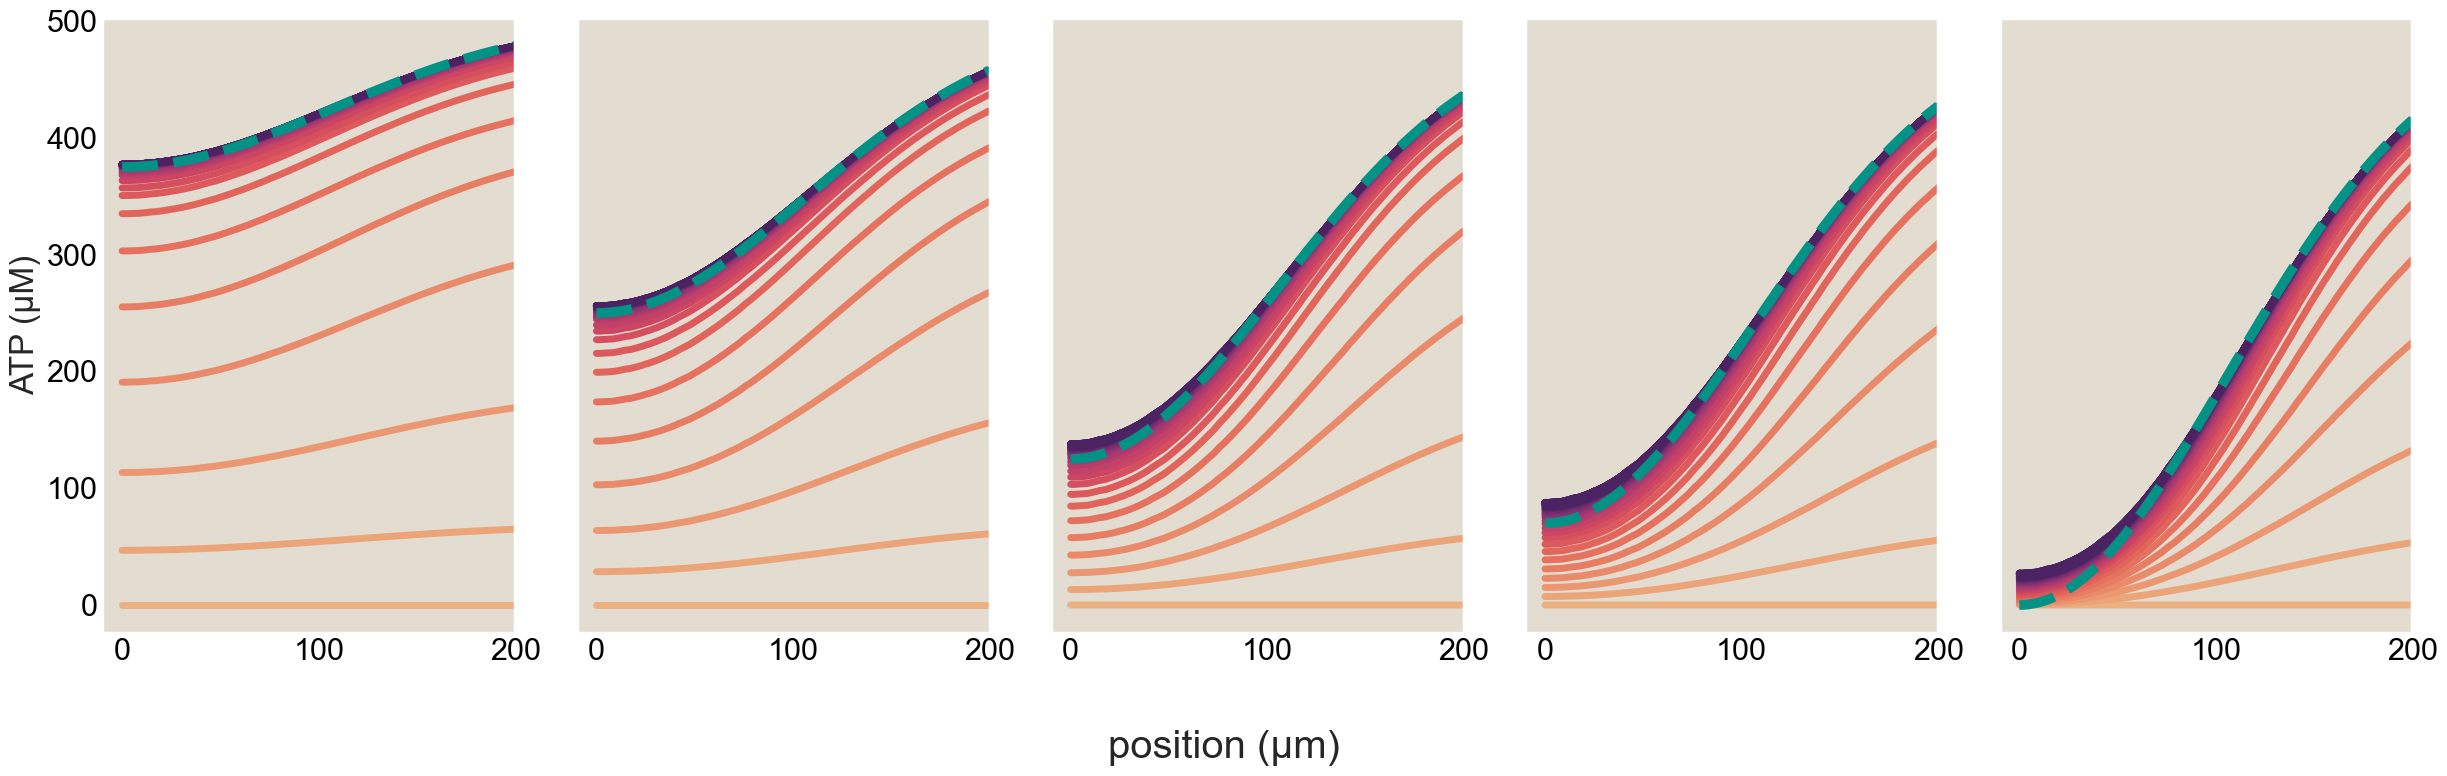

In [35]:
global_time=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=0, vmax=20)(time))
fig, ax = plt.subplots(1, 5, figsize=(25, 8), sharex=True, sharey=True)

for i, w in enumerate(np.unique(wellDepths)):
    subsetdf=comsol_Qb_prof_df[comsol_Qb_prof_df['wellDepth']==w]
    plot_pos = subsetdf[subsetdf['time (s)']==0]['position (µm)']
    for t, time in enumerate(np.unique(subsetdf['time (s)'])):
        if t%2==0:
            ax[i].plot(subsetdf[subsetdf['time (s)']==time]['position (µm)'],
                       subsetdf[subsetdf['time (s)']==time]['Qb as ATP (µM)'],
                       color=global_time(time),
                       lw=5
                      )
     
    ax[i].plot(plot_pos, 500*(1-w*np.exp(-plot_pos**2/150**2)), c='xkcd:teal', ls='--', lw=7)

    ax[i].set_xlim(-10, 200)

fig.supxlabel('position (µm)')
ax[0].set_ylabel('ATP (µM)')
plt.tight_layout()


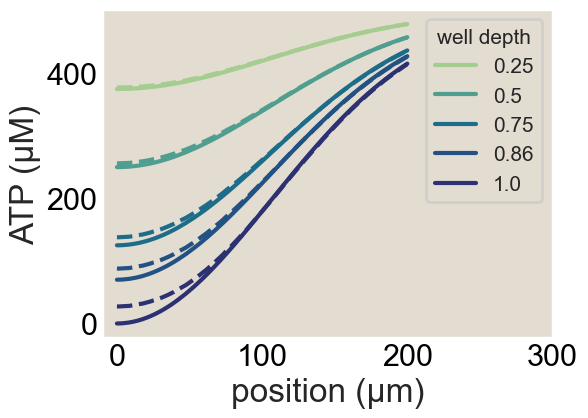

In [36]:
wellDepthcmap=lambda w:sns.color_palette("crest", as_cmap=True)(matplotlib.colors.Normalize(vmin=min(wellDepths), vmax=max(wellDepths))(w))

fig, ax = plt.subplots()

for i, w in enumerate(np.unique(wellDepths)):
    subsetdf=comsol_Qb_prof_df[comsol_Qb_prof_df['wellDepth']==w]
    plot_pos = subsetdf[subsetdf['time (s)']==0]['position (µm)']
    ax.plot(subsetdf[subsetdf['time (s)']==max(subsetdf['time (s)'])]['position (µm)'],
                       subsetdf[subsetdf['time (s)']==max(subsetdf['time (s)'])]['Qb as ATP (µM)'],
                       color=wellDepthcmap(w),
                       lw=3,
                       ls='--',
                      )
    ax.plot(plot_pos, 500*(1-w*np.exp(-plot_pos**2/150**2)), c=wellDepthcmap(w), lw=3, label=w)

ax.set_xlim(-10, 300)

ax.set_xlabel('position (µm)')
ax.set_ylabel('ATP (µM)')
ax.legend(title='well depth', fontsize=15, title_fontsize=15)
plt.tight_layout()

#plt.savefig('../../analyzed_data/probeBlurring/20251011_QbVaryWellDepth.pdf', bbox_inches='tight')


In [37]:
def probeATPcurves(r, a, A0, wellDepth):    
    return A0*(1 - wellDepth*np.exp(-r**2/a**2))

def prepForExpFit(probeATP, A0, wellDepth):
    return (1 - (probeATP/A0))/wellDepth

def ExpFit(r, a):
    return np.exp(-r**2/a**2)

#Curve-fit to the Langmuir curve
def probeATP_Expfit(r, preppedProbeATP, p0, maxpos, A0, wellDepth): 
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ExpFit, 
                                 r, 
                                 preppedProbeATP,
                                 p0, 
                                 bounds = (np.zeros(1), np.ones([1])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxpos,maxpos)
    curve = probeATPcurves(xvals, param[0], A0, wellDepth)
    
    return param, curve, xvals


In [38]:
test = probeATP_Expfit(subsetdf[subsetdf['time (s)']==time]['position (µm)'],
               prepForExpFit(subsetdf[subsetdf['time (s)']==time]['Qb as ATP (µM)'], 500, w),
               [100],
               200,
               500,
               w)

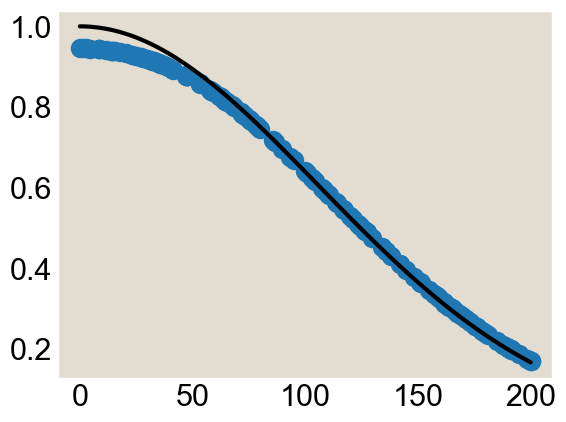

In [39]:
plt.scatter(subsetdf[subsetdf['time (s)']==time]['position (µm)'], prepForExpFit(subsetdf[subsetdf['time (s)']==time]['Qb as ATP (µM)'], 500, w))
plt.plot(subsetdf[subsetdf['time (s)']==time]['position (µm)'], ExpFit(subsetdf[subsetdf['time (s)']==time]['position (µm)'], test[0]), c='k')

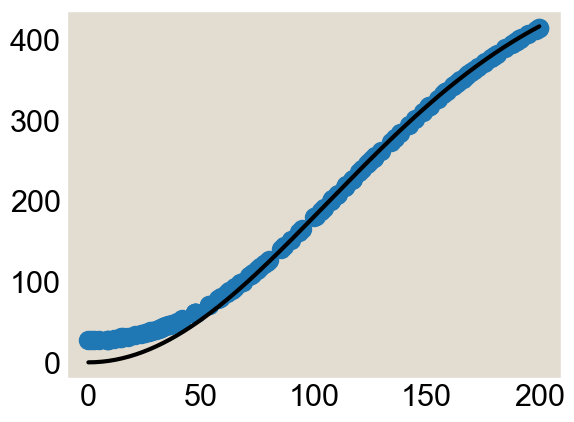

In [40]:
plt.scatter(subsetdf[subsetdf['time (s)']==time]['position (µm)'], subsetdf[subsetdf['time (s)']==time]['Qb as ATP (µM)'])
plt.plot(test[2], test[1], c='k')

TypeError: 'function' object is not subscriptable

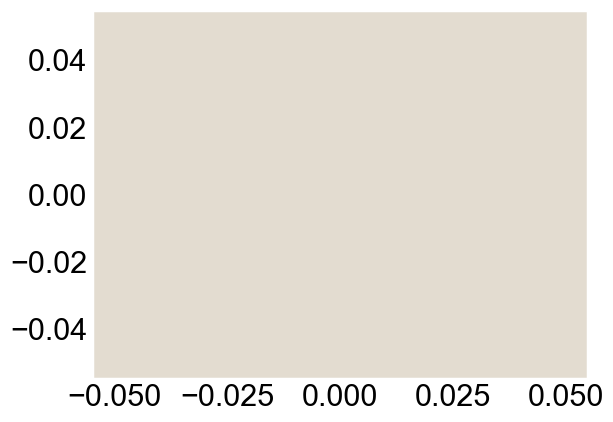

In [41]:
probeATPfits = []
for i, w in enumerate(np.unique(wellDepths)):
    temp_df = comsol_Qb_prof_df[(comsol_Qb_prof_df['time (s)']==4000)&(comsol_Qb_prof_df['wellDepth']==w)]
    temp_fit = lambda r, probeATP, w, A0, p0:curve_fit(A0*(1 - w*np.exp(-r**2/a**2)), r, probeATP, p0, bounds = (np.zeros(1), np.ones([1])*np.inf))
    
    # probeATPcurves_fit(temp_df['position (µm)'], 
    #                               temp_df['Qb as ATP (µM)'],
    #                               200,
    #                               w,
    #                               [100],)[0]
    probeATPfits.append(temp_fit)
    plt.scatter(temp_df['position (µm)'], temp_df['Qb as ATP (µM)'], s=30, alpha=0.8)
    plt.plot(temp_df['position (µm)'], probeATPcurves(temp_df['position (µm)'], temp_fit[0], w))
plt.xlim(-10, 200)

In [322]:
probeATPfits

[array([151.38321643,   0.2444691 ]),
 array([151.85291595,   0.48692348]),
 array([152.65549034,   0.72540886]),
 array([153.2065669 ,   0.82802039]),
 array([154.2269504 ,   0.95504672])]

# sample time evolution -- i believe this is outdated from the first try, the cells above cover this section move on to next

In [252]:
molperm3_to_uM = 1e3
mtoum = 1e6

comsol_file_path = '../../data/COMSOL/probeBlurring/'
comsol_file_name = '20250926_probeblurring_fixedGaussATP'
comsol_file_type = '.csv'
comment = '%'
comsol_Qb_prof_df = pd.read_csv(comsol_file_path + comsol_file_name + comsol_file_type, comment=comment, names=["position (µm)", "Qb (µM)"])
#comsol_mot_prof_df = pd.read_csv(comsol_file_path + 'xzproj_D6_timedepmot_motornotProjected' + comsol_file_type, comment=comment, names=["position (µm)", "Mot (µM)"])
#probe to ATP calibration
comsol_Qb_prof_df['Qb as ATP (µM)'] = ATP_ratio_to_conc(comsol_Qb_prof_df['Qb (µM)'], comsol_cal_fit_justKd[0][0], 2.5, 0, 1)


#convert positions to µm
comsol_Qb_prof_df['position (µm)'] = comsol_Qb_prof_df['position (µm)']*mtoum

t_start = 0 #initial time
t_end = 20 # final time
spacing = 1 # seconds between each measurement
interval = 1 #plotting interval

numb_times = int((t_end-t_start)/spacing)+1

comsol_times = np.linspace(t_start, t_start+spacing*(numb_times-1), numb_times) #given in s
tot_points = len(comsol_Qb_prof_df['position (µm)'])
numb_points = int(tot_points/numb_times)

comsol_time_ls = []
for t in comsol_times:
    for i in range(numb_points):
        comsol_time_ls.append(t)
        
comsol_Qb_prof_df['time (s)']= comsol_time_ls

# depth = 60e-6 #m
# comsol_ATP_prof_df['ATP Conc'] = comsol_ATP_prof_df['ATP (mol/m^3)']/depth * molperm3_to_uM

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_43002/314658805.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


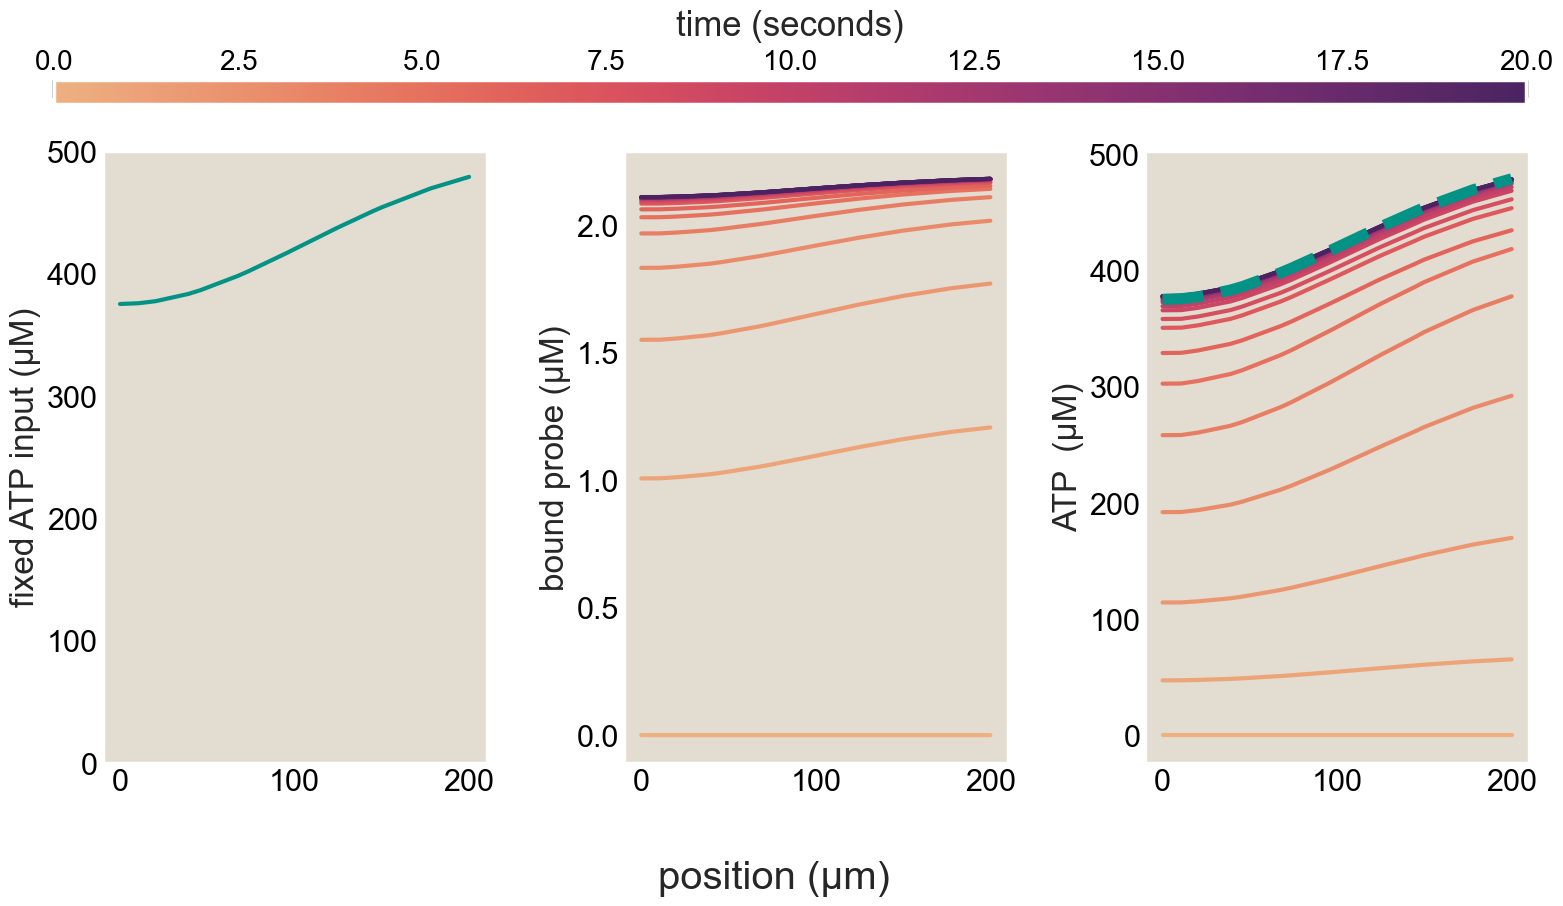

In [253]:
global_time=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=t_start, vmax=t_end)(time))


fig, ax = plt.subplots(1,3, figsize = (16, 8))

plot_pos = comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==0]['position (µm)']

ax[0].plot(plot_pos, 500*(1-0.25*np.exp(-plot_pos**2/150**2)), color='xkcd:teal')
ax[0].set_ylim(0,500)

for t, time in enumerate(np.unique(comsol_time_ls)):
    if t%1==0:
        ax[1].plot(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                  comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb (µM)'],
                  color=global_time(time))

        ax[2].plot(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb as ATP (µM)'],
                  color=global_time(time))
        
ax[2].plot(plot_pos, 500*(1-0.25*np.exp(-plot_pos**2/150**2)), c='xkcd:teal', ls='--', lw=8)
fig.supxlabel('position (µm)')
ax[0].set_ylabel('fixed ATP input (µM)')
ax[1].set_ylabel('bound probe (µM)')
ax[2].set_ylabel('ATP  (µM)')



# Adjust the top margin to make space for the colorbar
fig.subplots_adjust(top=0.85)
#fig.subplots_adjust(right=0.85)

# Create an axis for the colorbar that spans all columns
cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # horizontal [left, bottom, width, height]
#cax = fig.add_axes([1, 0.05, 0.03, 0.91])  # vertical [left, bottom, width, height]

# Create an axis for the colorbar that spans all columns
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=mcolors.Normalize(vmin=t_start, vmax=t_end)),cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (seconds)', fontsize=25, labelpad=10)

plt.tight_layout()

In [254]:
def probeATPcurves(r, a, b):    
    return 500*(1 - b*np.exp(-r**2/a**2))



#Curve-fit to the Langmuir curve
def probeATPcurves_fit(r, probeATP, maxpos, p0): 
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(probeATPcurves, 
                                 r, 
                                 probeATP,
                                 p0, 
                                 bounds = (np.zeros(2), np.ones([2])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxpos,maxpos)
    curve = probeATPcurves(xvals, param[0], param[1])
    
    return param, curve, xvals


In [255]:
probeATPfits=[]
for t, time in enumerate(np.unique(comsol_time_ls)):
    probeATPfits.append(probeATPcurves_fit(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'], 
                                           comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb as ATP (µM)'],
                                           200,
                                           [100,0.25],)[0])

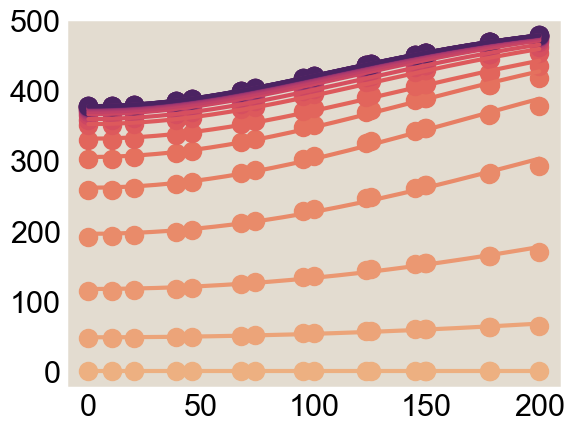

In [256]:
global_time=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=t_start, vmax=t_end)(time))


fig, ax = plt.subplots()

for t, time in enumerate(np.unique(comsol_time_ls)):
    if t%1==0:
        ax.scatter(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb as ATP (µM)'],
                  color=global_time(time))
        ax.plot(np.linspace(0, 200, 201), 
                probeATPcurves(np.linspace(0, 200, 201), probeATPfits[t][0], probeATPfits[t][1]),
               color=global_time(time))

In [120]:
np.array(probeATPfits)[:,0]

array([2.07566713e+05, 9.28716132e+02, 4.70941253e+02, 2.91166761e+02,
       2.16041703e+02, 1.85288644e+02, 1.74263582e+02, 1.55463809e+02,
       1.47213106e+02, 1.38970947e+02, 1.35453269e+02, 1.32048667e+02,
       1.30626498e+02, 1.29271114e+02, 1.28711945e+02, 1.28183059e+02,
       1.27966728e+02, 1.27762909e+02, 1.27680127e+02, 1.27602301e+02,
       1.27570906e+02])

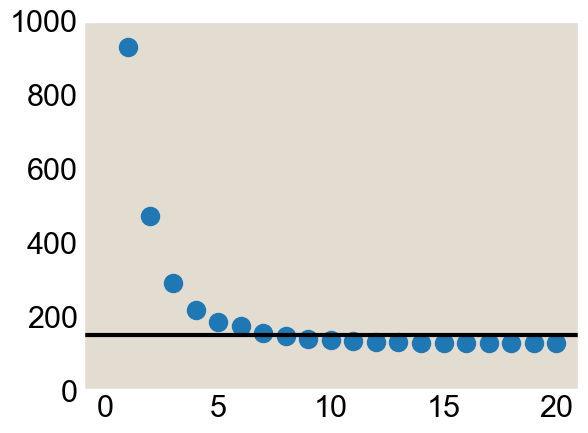

In [129]:
plt.scatter(np.linspace(0, 20, 21), np.array(probeATPfits)[:,0])
plt.ylim(0, 1000)
plt.axhline(150, color='k')

In [114]:
probeATPfits

[array([2.07566713e+05, 9.99996794e-01]),
 array([9.28716132e+02, 8.98978587e-01]),
 array([470.94125347,   0.75563774]),
 array([291.16676107,   0.59215469]),
 array([216.04170258,   0.45600082]),
 array([185.28864426,   0.36560175]),
 array([174.26358246,   0.31149359]),
 array([155.46380946,   0.26894776]),
 array([147.21310563,   0.254465  ]),
 array([138.97094735,   0.24029362]),
 array([135.45326944,   0.23357156]),
 array([132.04866704,   0.2270781 ]),
 array([130.62649811,   0.2240408 ]),
 array([129.27111357,   0.22113035]),
 array([128.71194473,   0.21978084]),
 array([128.18305877,   0.21849298]),
 array([127.96672838,   0.21789901]),
 array([127.76290939,   0.21733332]),
 array([127.6801272 ,   0.21707335]),
 array([127.6023014 ,   0.21682599]),
 array([127.57090555,   0.21671262])]

fit gaussian to ATP and try to get a length scale for steady state

In [14]:
comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb (µM)'].max()

2.180980524639204

In [589]:
molperm3_to_uM = 1e3
mtoum = 1e6

comsol_file_path = '../../data/COMSOL/probeBlurring/'
comsol_file_name = '20251005_probeblurring_fixedGaussATP_wellDepth1_40severy0pt5'
comsol_file_type = '.csv'
comment = '%'
comsol_Qb_prof_df = pd.read_csv(comsol_file_path + comsol_file_name + comsol_file_type, comment=comment, names=["position (µm)", "Qb (µM)"])
#comsol_mot_prof_df = pd.read_csv(comsol_file_path + 'xzproj_D6_timedepmot_motornotProjected' + comsol_file_type, comment=comment, names=["position (µm)", "Mot (µM)"])

#convert positions to µm
comsol_Qb_prof_df['position (µm)'] = comsol_Qb_prof_df['position (µm)']*mtoum
comsol_Qb_prof_df['Qb (µM)'] = comsol_Qb_prof_df['Qb (µM)']*molperm3_to_uM

#probe to ATP calibration
comsol_Qb_prof_df['Qb as ATP (µM)'] = ATP_ratio_to_conc(comsol_Qb_prof_df['Qb (µM)'], 70, 2.8, 0, 1)

t_start = 0 #initial time
t_end = 40 # final time
spacing = 0.5 # seconds between each measurement
interval = 1 #plotting interval

numb_times = int((t_end-t_start)/spacing)+1

comsol_times = np.linspace(t_start, t_start+spacing*(numb_times-1), numb_times) #given in s
tot_points = len(comsol_Qb_prof_df['position (µm)'])
numb_points = int(tot_points/numb_times)

comsol_time_ls = []
for t in comsol_times:
    for i in range(numb_points):
        comsol_time_ls.append(t)
        
comsol_Qb_prof_df['time (s)']= comsol_time_ls

In [590]:
comsol_Qb_prof_df

,position (µm),Qb (µM),Qb as ATP (µM),time (s)
0,0.000000,0.000001,0.000029,0.0
1,10.657576,0.000001,0.000034,0.0
2,20.293376,0.000004,0.000097,0.0
3,38.912912,0.000011,0.000275,0.0
4,45.738850,0.000015,0.000373,0.0
...,...,...,...,...
10363,1444.424871,2.456140,499.998992,40.0
10364,1449.953112,2.456140,499.998992,40.0
10365,1454.810792,2.456140,499.998992,40.0
10366,1474.976556,2.456140,499.998992,40.0


/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_43002/589961171.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


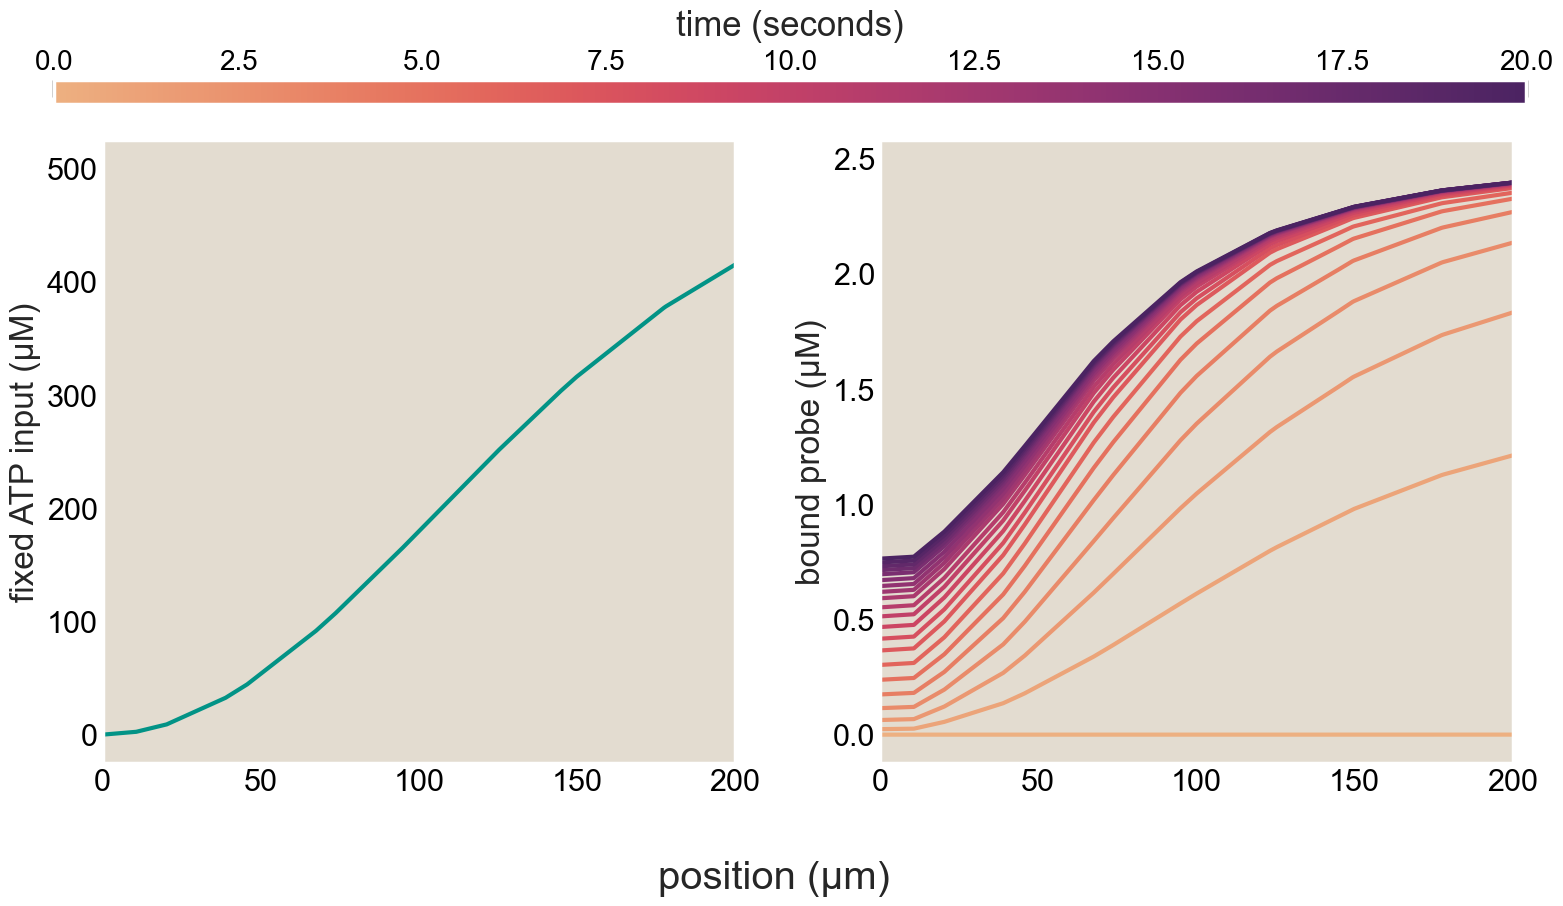

In [591]:
tplotstart = t_start
tplotend = 20
global_time=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=tplotstart, vmax=tplotend)(time))


fig, ax = plt.subplots(1,2, figsize = (16, 8), sharex=True)

plot_pos = comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==0]['position (µm)']

ax[0].plot(plot_pos, 500*(1-1*np.exp(-plot_pos**2/150**2)), color='xkcd:teal')
#ax[0].set_ylim(0,500)

for t, time in enumerate(np.unique(comsol_time_ls)[np.unique(comsol_time_ls)<=20]):
    if t%2==0:
        ax[1].plot(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                  comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb (µM)'],
                  color=global_time(time))
        
fig.supxlabel('position (µm)')
ax[0].set_ylabel('fixed ATP input (µM)')
ax[1].set_ylabel('bound probe (µM)')

ax[0].set_xlim(0, 200)

# Adjust the top margin to make space for the colorbar
fig.subplots_adjust(top=0.85)
#fig.subplots_adjust(right=0.85)

# Create an axis for the colorbar that spans all columns
cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # horizontal [left, bottom, width, height]
#cax = fig.add_axes([1, 0.05, 0.03, 0.91])  # vertical [left, bottom, width, height]

# Create an axis for the colorbar that spans all columns
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=mcolors.Normalize(vmin=tplotstart, vmax=tplotend)),cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (seconds)', fontsize=25, labelpad=10)

plt.tight_layout()

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_43002/2023030618.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


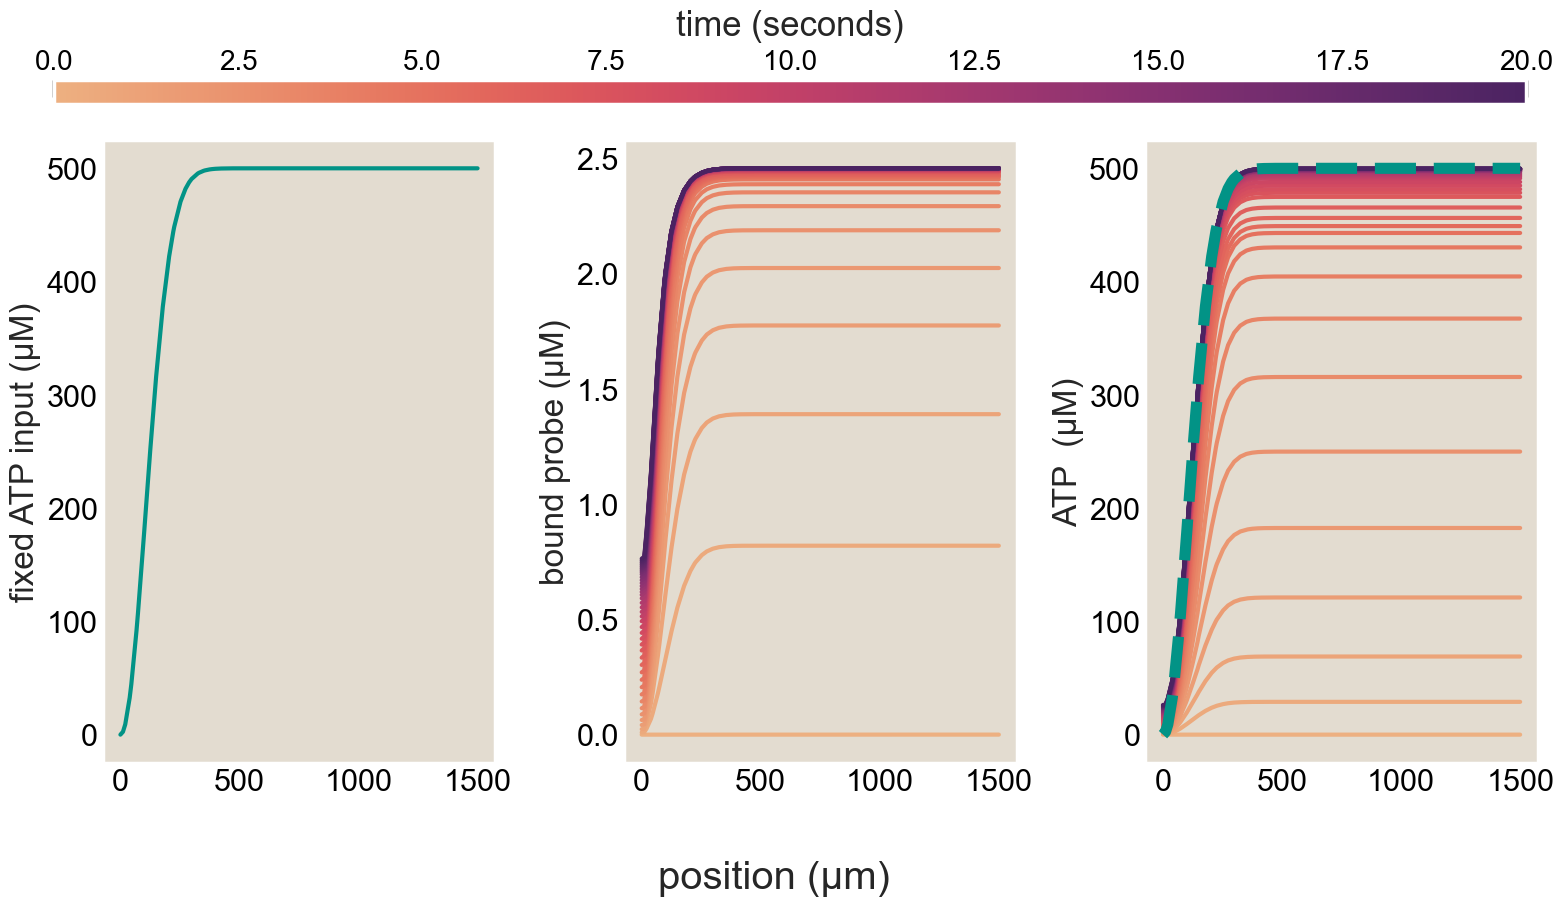

In [592]:
tplotstart = t_start
tplotend = 20
global_time=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=tplotstart, vmax=tplotend)(time))


fig, ax = plt.subplots(1,3, figsize = (16, 8))

plot_pos = comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==0]['position (µm)']

ax[0].plot(plot_pos, 500*(1-1*np.exp(-plot_pos**2/150**2)), color='xkcd:teal')
#ax[0].set_ylim(0,500)

for t, time in enumerate(np.unique(comsol_time_ls)[np.unique(comsol_time_ls)<=20]):
    if t%1==0:
        ax[1].plot(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                  comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb (µM)'],
                  color=global_time(time))

        ax[2].plot(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb as ATP (µM)'],
                  color=global_time(time))
        
ax[2].plot(plot_pos, 500*(1-1*np.exp(-plot_pos**2/150**2)), c='xkcd:teal', ls='--', lw=8)
fig.supxlabel('position (µm)')
ax[0].set_ylabel('fixed ATP input (µM)')
ax[1].set_ylabel('bound probe (µM)')
ax[2].set_ylabel('ATP  (µM)')



# Adjust the top margin to make space for the colorbar
fig.subplots_adjust(top=0.85)
#fig.subplots_adjust(right=0.85)

# Create an axis for the colorbar that spans all columns
cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # horizontal [left, bottom, width, height]
#cax = fig.add_axes([1, 0.05, 0.03, 0.91])  # vertical [left, bottom, width, height]

# Create an axis for the colorbar that spans all columns
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=mcolors.Normalize(vmin=tplotstart, vmax=tplotend)),cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (seconds)', fontsize=25, labelpad=10)

plt.tight_layout()


/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_43002/1428156051.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


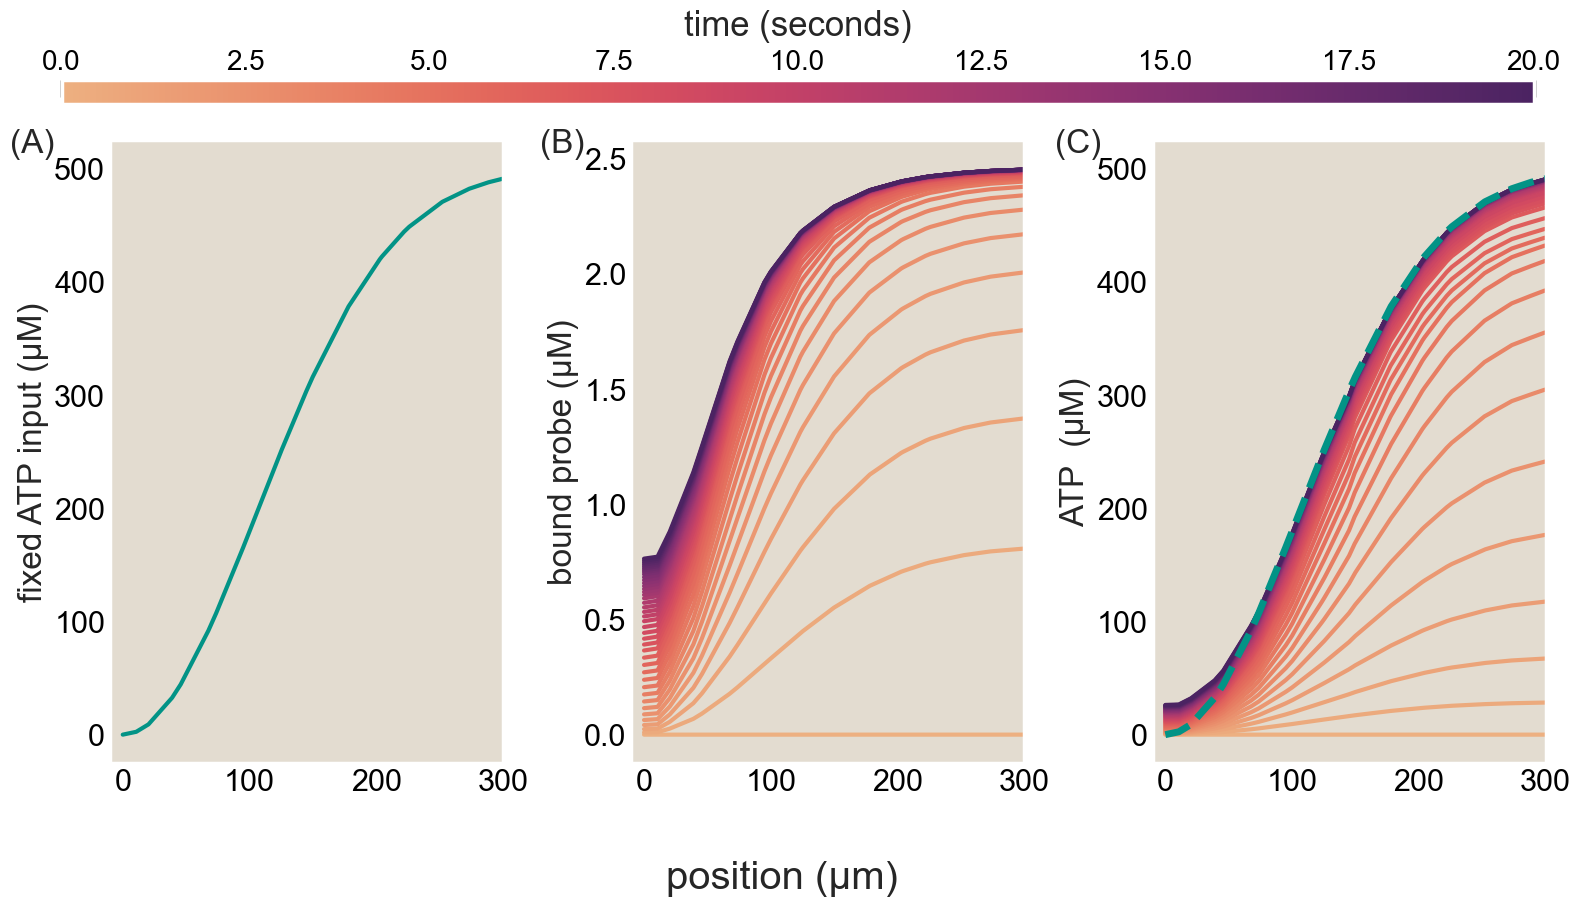

In [593]:
tplotstart = t_start
tplotend = 20
global_time=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=tplotstart, vmax=tplotend)(time))


fig, ax = plt.subplots(1,3, figsize = (16, 8), sharex=True)

plot_pos = comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==0]['position (µm)']

ax[0].plot(plot_pos, 500*(1-1*np.exp(-plot_pos**2/150**2)), color='xkcd:teal')
#ax[0].set_ylim(0,500)

for t, time in enumerate(np.unique(comsol_time_ls)[np.unique(comsol_time_ls)<=20]):
    if t%1==0:
        ax[1].plot(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                  comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb (µM)'],
                  color=global_time(time))

        ax[2].plot(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb as ATP (µM)'],
                  color=global_time(time))
        
ax[2].plot(plot_pos, 500*(1-1*np.exp(-plot_pos**2/150**2)), c='xkcd:teal', ls='--', lw=5)
fig.supxlabel('position (µm)')
ax[0].set_ylabel('fixed ATP input (µM)')
ax[1].set_ylabel('bound probe (µM)')
ax[2].set_ylabel('ATP  (µM)')

ax[0].set_xlim(-10, 300)

# Adjust the top margin to make space for the colorbar
fig.subplots_adjust(top=0.85)
#fig.subplots_adjust(right=0.85)

# Create an axis for the colorbar that spans all columns
cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # horizontal [left, bottom, width, height]
#cax = fig.add_axes([1, 0.05, 0.03, 0.91])  # vertical [left, bottom, width, height]

# Create an axis for the colorbar that spans all columns
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=mcolors.Normalize(vmin=tplotstart, vmax=tplotend)),cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (seconds)', fontsize=25, labelpad=10)

plt.text(-0.7, -40, '(A)',)
plt.text(6.5, -40, '(B)',)
plt.text(13.5, -40, '(C)',)
plt.tight_layout()

plt.savefig('../../analyzed_data/probeBlurring/20251009_QbplotsfixedA.pdf', bbox_inches='tight')

Text(0, 0.5, 'ATP (µM)')

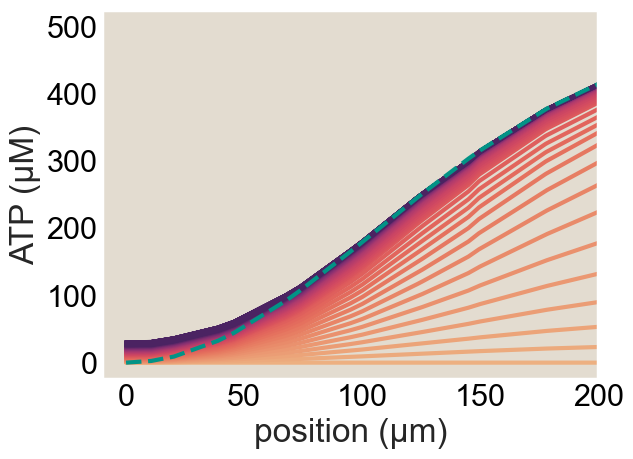

In [442]:
for t, time in enumerate(np.unique(comsol_time_ls)):
    plt.plot(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['position (µm)'],
                comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==time]['Qb as ATP (µM)'],
                  color=global_time(time))
     
plt.plot(plot_pos, 500*(1-1*np.exp(-plot_pos**2/150**2)), c='xkcd:teal', ls='--', lw=3)
plt.xlim(-10, 200)

plt.xlabel('position (µm)')
plt.ylabel('ATP (µM)')

In [147]:
np.sum(500*(1-1*np.exp(-plot_pos**2/150**2))), np.sum(500*(1-1*np.exp(-plot_pos**2/150**2)))

58403.77076392318

In [164]:
np.sum(comsol_Qb_prof_df[comsol_Qb_prof_df['time (s)']==18.0]['Qb as ATP (µM)'])

58462.40041298903

Try fitting ATP curve

In [366]:
def read_h5py(path_name, excludes=[]):
    # Glob for directory parsing to get all .h5 files in the specified path
    h5files = glob.glob(path_name + '/*.h5')
    for excl in excludes:
        h5files=[file for file in h5files if excl not in file]
        
    #print("HDF5 files found:", h5files)
    
    # Dictionary to store arrays from each file
    all_data = {}
    
    for file in h5files:
        file_data = []  # List to hold datasets for the current file
        
        with h5py.File(file, 'r') as h5file:
            def load_data(name, obj):
                if isinstance(obj, h5py.Dataset):
                    file_data.append(obj[:])  # Append dataset as a NumPy array
            
            # Visit all datasets in the file and load them into file_data
            h5file.visititems(load_data)
        
        #slice by 8 since the date has 8 didgits
        field_name = file.split('.h5')[0].split('tif')[-1][15:] #BRO, 15 is the number of digits in how we save datetime -> 20241114_201131 (formerly we had 8 since we didnt include time)
        #print(file + '\n')
        #print(field_name+ '\n')
            
        # Add this file's data to all_data with the filename as the key
        all_data[field_name] = file_data[0]
        
        
    return all_data

In [379]:
umperpixel=0.59
postergname =  '../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'

h5spath=postergname.split('data')[0]+'analyzed_data'+postergname.split('data')[1]+'/'
h5dic = read_h5py(h5spath)

# this is (numTimes, numRbinMidpoints)
# rMotmids=h5dic['all_rMotbins']*umperpixel
# rMotavgs=h5dic['all_rMotavgs']
# timesMot=h5dic['timesMot']

rATPmids=h5dic['all_rATPbins']*6*umperpixel #*6 bcause of downsampling
rATPavgs=h5dic['all_rATPavgs']
timesATP=h5dic['timesATP']

global_timeCmap_ATP=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=timesATP.min(), vmax=timesATP.max())(time))

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_43002/2714396737.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


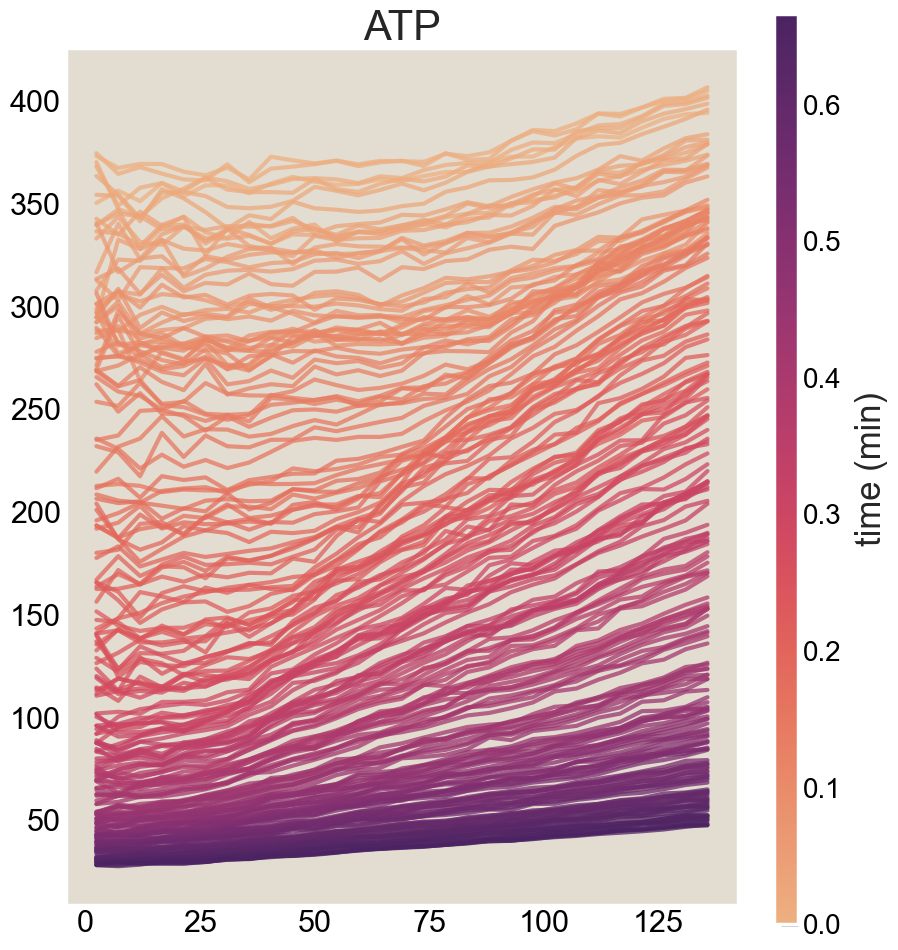

In [581]:
fig, ax = plt.subplots(1, figsize=(8,10))
#for time in range(rMotmids.shape[0]):
    # ax[0].plot(rMotmids[time,:],
    #          rMotavgs[time,:], 
    #          alpha=0.75,
    #          color=global_time(timesMot[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        

for time in range(rATPmids.shape[0]):
    ax.plot(rATPmids[time,:],
                           rATPavgs[time,:], alpha=0.75, 
                           color=global_timeCmap_ATP(timesATP[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        


ax.set_title('ATP', fontsize=30)

# Adjust the top margin to make space for the colorbar
#fig.subplots_adjust(top=0.85)
fig.subplots_adjust(right=0.85)

# Create an axis for the colorbar that spans all columns
#cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # [left, bottom, width, height]
cax = fig.add_axes([1, 0.05, 0.03, 0.91])  # [left, bottom, width, height]

# Create the colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=mcolors.Normalize(vmin=min(comsol_time_ls)/60, 
                                                                 vmax=max(comsol_time_ls)/60)),
                    cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (min)', fontsize=25, labelpad=10)




fig.tight_layout()

#plt.savefig(h5spath+'MotorATPTraces.pdf', bbox_inches='tight')


# dynamic ATP

In [45]:
comsolDynamicQb_df = pd.read_csv(comsol_file_path + '20251011_probeblurring_dynamic0_400_4000_Qb' + comsol_file_type, comment=comment, names=["position (µm)", "Qb (µM)"])
comsolDynamicA_df = pd.read_csv(comsol_file_path + '20251011_probeblurring_dynamic0_400_4000_A' + comsol_file_type, comment=comment, names=["position (µm)", "A (µM)"])
comsolDynamicmot_df = pd.read_csv(comsol_file_path + '20251011_probeblurring_dynamic0_400_4000_mot' + comsol_file_type, comment=comment, names=["position (µm)", "mot (µM)"])


# comsolDynamicQb_df = pd.read_csv(comsol_file_path + '20251008_probeblurring_dynamic0_400_4000_Qb' + comsol_file_type, comment=comment, names=["position (µm)", "Qb (µM)"])
# comsolDynamicA_df = pd.read_csv(comsol_file_path + '20251008_probeblurring_dynamic0_400_4000_A' + comsol_file_type, comment=comment, names=["position (µm)", "A (µM)"])
# comsolDynamicmot_df = pd.read_csv(comsol_file_path + '20251008_probeblurring_dynamic0_400_4000_mot' + comsol_file_type, comment=comment, names=["position (µm)", "mot (µM)"])

comsolDynamic_df = comsolDynamicQb_df.copy()
comsolDynamic_df['A (µM)'] = comsolDynamicA_df['A (µM)']
comsolDynamic_df['mot (µM)'] = comsolDynamicmot_df['mot (µM)']

#fix concentrations
comsolDynamic_df['Qb (µM)'] = comsolDynamic_df['Qb (µM)']*molperm3_to_uM
comsolDynamic_df['A (µM)'] = comsolDynamic_df['A (µM)']*molperm3_to_uM
comsolDynamic_df['mot (µM)'] = comsolDynamic_df['mot (µM)']*molperm3_to_uM

#fix position units
comsolDynamic_df['position (µm)'] = comsolDynamicQb_df['position (µm)']*mtoum

comsolDynamic_df['Qb as ATP (µM)'] = ATP_ratio_to_conc(comsolDynamic_df['Qb (µM)'], 70, 2.8, 0, 1)

comsol_time_ls = comsolTimeGenerator(0, 4000, 400, 1, comsolDynamic_df['position (µm)'])
comsolDynamic_df['time (s)']= comsol_time_ls

comsolDynamic_df

,position (µm),Qb (µM),A (µM),mot (µM),Qb as ATP (µM),time (s)
0,0.000000,2.454663,499.997784,0.579434,497.561181,0.0
1,1.219209,2.454663,499.997784,0.579434,497.561181,0.0
2,2.610780,2.454663,499.997784,0.579434,497.561181,0.0
3,4.703201,2.454663,499.997784,0.579434,497.561181,0.0
4,8.363899,2.454663,499.997784,0.579434,497.561181,0.0
...,...,...,...,...,...,...
1370,191.841207,0.903811,33.189464,0.548062,33.365247,4000.0
1371,194.903875,0.905183,33.264254,0.548052,33.440041,4000.0
1372,198.372515,0.906746,33.349564,0.548041,33.525478,4000.0
1373,199.927241,0.907413,33.386028,0.548038,33.561939,4000.0


/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_99738/2163857834.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


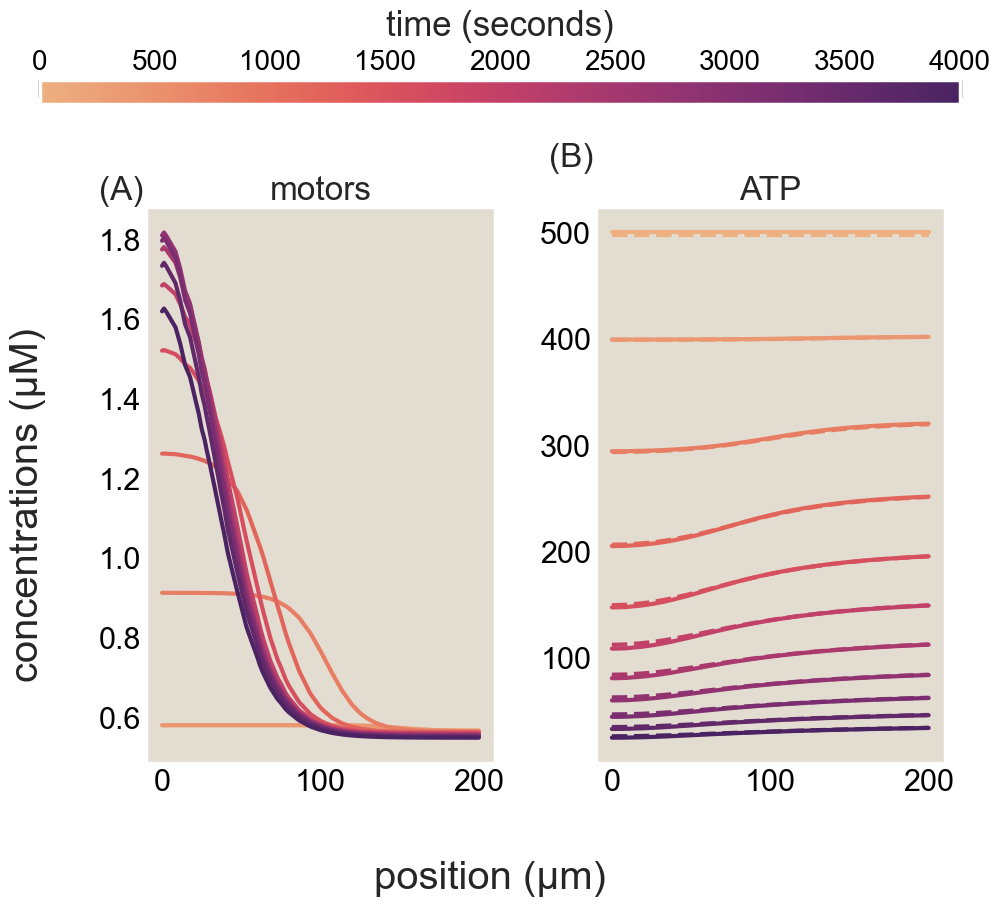

In [46]:
global_time=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=min(comsol_time_ls), vmax=max(comsol_time_ls))(time))
fig, ax= plt.subplots(1,2,figsize=(10,8))
for t, time in enumerate(np.unique(comsol_time_ls)):
    ax[0].plot(comsolDynamic_df[comsolDynamic_df['time (s)']==time]['position (µm)'],
              comsolDynamic_df[comsolDynamic_df['time (s)']==time]['mot (µM)'],
              lw=3,
              color=global_time(time))
    
    ax[1].plot(comsolDynamic_df[comsolDynamic_df['time (s)']==time]['position (µm)'],
              comsolDynamic_df[comsolDynamic_df['time (s)']==time]['A (µM)'],
              lw=3,
              color=global_time(time))
    ax[1].plot(comsolDynamic_df[comsolDynamic_df['time (s)']==time]['position (µm)'],
             comsolDynamic_df[comsolDynamic_df['time (s)']==time]['Qb as ATP (µM)'],
             lw=3,
             ls='--',
             color=global_time(time))
    
ax[0].text(-40, 1.9, '(A)',)
ax[1].text(-40, 562, '(B)',)

# Adjust the top margin to make space for the colorbar
fig.subplots_adjust(top=0.85)
#fig.subplots_adjust(right=0.85)

# Create an axis for the colorbar that spans all columns
cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # horizontal [left, bottom, width, height]
#cax = fig.add_axes([1, 0.05, 0.03, 0.91])  # vertical [left, bottom, width, height]

# Create an axis for the colorbar that spans all columns
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=mcolors.Normalize(vmin=min(comsol_time_ls), vmax=max(comsol_time_ls))),cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (seconds)', fontsize=25, labelpad=10)   

fig.supxlabel('position (µm)')
ax[1].set_title('ATP')
ax[0].set_title('motors')
fig.supylabel('concentrations (µM)')
plt.tight_layout()

#fig.savefig('../../analyzed_data/probeBlurring/20251009_QbDynamicMotandA.pdf', bbox_inches='tight')

In [44]:
comsolDynamicQb_df = pd.DataFrame(columns=["position (µm)", "A (µM)", "Qb (µM)", 'Qb as ATP (µM)', 'time (s)', "wellDepth"])
comsolDynamicA_df = pd.DataFrame(columns=["position (µm)", "A (µM)", "Qb (µM)", 'Qb as ATP (µM)', 'time (s)', "wellDepth"])

wellDepths = [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.86, 0.86, 1, 1]

for f, file in enumerate(variedWellDepthFiles):
    temp_df = pd.read_csv(comsol_file_path + file + comsol_file_type, comment=comment, names=["position (µm)", "Qb (µM)"])
    temp_df['position (µm)'] = temp_df['position (µm)']*mtoum
    temp_df['Qb (µM)'] = temp_df['Qb (µM)']*molperm3_to_uM
    temp_df['Qb as ATP (µM)'] = ATP_ratio_to_conc(temp_df['Qb (µM)'], 70, 2.8, 0, 1)
    
    if '40severy0pt5' in file:
        t_start = 0 #initial time
        t_end = 40 # final time
        spacing = 0.5 # seconds between each measurement
        interval = 1 #plotting interval
    else:
        t_start = 0 #initial time
        t_end = 4000 # final time
        spacing = 200 # seconds between each measurement
        interval = 1 #plotting interval
    
    comsol_time_ls = comsolTimeGenerator(t_start, t_end, spacing, interval, temp_df['position (µm)'])
    temp_df['time (s)']= comsol_time_ls
    
    temp_df['wellDepth'] = wellDepths[f]*np.ones(len(temp_df))
    
    if '4000severy200' in file:
        temp_df=temp_df[temp_df['time (s)']!=0]
    
    comsol_Qb_prof_df=pd.concat([comsol_Qb_prof_df, temp_df])

        
